In [ ]:
!pip install dgl-cu113 -f https://data.dgl.ai/wheels/repo.html

Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 152.9 MB 29 kB/s 


In [ ]:
import dgl
dgl.__version__

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


'0.7.2'

In [ ]:
import argparse
from os import path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from dgl import batch
from dgl.data.ppi import LegacyPPIDataset
from dgl.nn.pytorch import GraphConv
#from dgl.nn.pytorch import GATConv
from dgl.nn import GATConv
from sklearn.metrics import f1_score
from torch import nn, optim
from torch.utils.data import DataLoader
import os

In [ ]:
seed = 0
torch.manual_seed(seed)

In [ ]:
#MODEL_STATE_FILE = "model_state.pth"
MODEL_STATE_FILE = 'experiment/model_200.pth'

In [ ]:
#create experiments folder
experiment = './experiment'

# Create experiment folder
if not os.path.isdir(experiment):
    os.makedirs(experiment)

In [ ]:
class BasicGraphModel(nn.Module):

    def __init__(self, g, n_layers, input_size, hidden_size, output_size, nonlinearity):
        super().__init__()

        self.g = g
        self.layers = nn.ModuleList()
        self.layers.append(GraphConv(input_size, hidden_size, activation=nonlinearity))
        for i in range(n_layers - 1):
            self.layers.append(GraphConv(hidden_size, hidden_size, activation=nonlinearity))
        self.layers.append(GraphConv(hidden_size, output_size))

    def forward(self, inputs):
        outputs = inputs
        for i, layer in enumerate(self.layers):
            outputs = layer(self.g, outputs)

        return outputs

In [ ]:
class GATNet(torch.nn.Module):
    def __init__(self, g, input_size, hidden_size, output_size, nonlinearity):
        super().__init__()
        self.g = g
        self.layers = nn.ModuleList()
        self.layers.append(GATConv(input_size, hidden_size, num_heads= 4, activation=nonlinearity))
        self.layers.append(GATConv(4 * hidden_size, hidden_size, num_heads= 4, residual=True,
                                   activation=nonlinearity))
        self.layers.append(GATConv(4 * hidden_size, output_size, num_heads= 6, residual=True))

    def forward(self, x):
        outputs = self.layers[0](self.g, x)
        for i in range(1, len(self.layers)):
            outputs = outputs.flatten(start_dim = 1)
            outputs = self.layers[i](self.g, outputs)
        return outputs.mean(axis=1)

In [ ]:
def main(args):

    # load dataset and create dataloader
    train_dataset, test_dataset = LegacyPPIDataset(mode="train"), LegacyPPIDataset(mode="test")
    train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, collate_fn=collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, collate_fn=collate_fn)
    n_features, n_classes = train_dataset.features.shape[1], train_dataset.labels.shape[1]

    # create the model, loss function and optimizer
    device = torch.device("cpu" if args.gpu < 0 else "cuda:" + str(args.gpu))
    if device == "cpu":
      print('using CPU')
    else:
      print('using GPU')

    ########### Replace this model with your own GNN implemented class ################################
    if args.model == 'basic':
      model = BasicGraphModel(g=train_dataset.graph, n_layers=args.nlayers, input_size=n_features, hidden_size=256,
                            output_size=n_classes, nonlinearity=F.elu).to(device)
    elif args.model == 'GAT':
      model = GATNet(g=train_dataset.graph, input_size=n_features, hidden_size=256,
                        output_size=n_classes,  nonlinearity=F.elu).to(device)
    
    ###################################################################################################

    loss_fcn = nn.BCEWithLogitsLoss()
    #learning rate used in the paper of GAT
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    # train
    if args.mode == "train":
        train(model, loss_fcn, device, optimizer, train_dataloader, test_dataset)
        #torch.save(model.state_dict(), MODEL_STATE_FILE)

    # import model from file
    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    model.load_state_dict(torch.load(MODEL_STATE_FILE, map_location=map_location))

    # test the model
    print('test phase:')
    test(model, loss_fcn, device, test_dataloader)

    return model

def train(model, loss_fcn, device, optimizer, train_dataloader, test_dataset):

    f1_score_list = []
    epoch_list = []
    all_scores = dict()

    for epoch in range(args.epochs):
        model.train()
        losses = []
        for batch, data in enumerate(train_dataloader):
            subgraph, features, labels = data
            subgraph = subgraph.to(device)
            features = features.to(device)
            labels = labels.to(device)
            model.g = subgraph
            for layer in model.layers:
                layer.g = subgraph
            logits = model(features.float())
            loss = loss_fcn(logits, labels.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            scores = []
            for batch, test_data in enumerate(test_dataset):
                subgraph, features, labels = test_data
                subgraph = subgraph.clone().to(device)
                features = features.clone().detach().to(device)
                labels = labels.clone().detach().to(device)
                score, _ = evaluate(features.float(), model, subgraph, labels.float(), loss_fcn)
                scores.append(score)
                f1_score_list.append(score)
                epoch_list.append(epoch)
            all_scores[epoch] = np.array(scores).mean()
            print("F1-Score: {:.4f} ".format(np.array(scores).mean()))
        #save model after each epoch
        model_file = 'experiment' + '/model_' + str(epoch) + '.pth'
        torch.save(model.state_dict(), model_file)
    ind = max(all_scores, key=all_scores.get)
    print(f'the model with the best test F1 score {all_scores[ind]} is model_{ind}')
    plot_f1_score(epoch_list, f1_score_list)

def test(model, loss_fcn, device, test_dataloader):
    test_scores = []
    for batch, test_data in enumerate(test_dataloader):
        subgraph, features, labels = test_data
        subgraph = subgraph.to(device)
        features = features.to(device)
        labels = labels.to(device)
        test_scores.append(evaluate(features, model, subgraph, labels.float(), loss_fcn)[0])
    mean_scores = np.array(test_scores).mean()
    print("F1-Score: {:.4f}".format(np.array(test_scores).mean()))
    return mean_scores

def evaluate(features, model, subgraph, labels, loss_fcn):
    with torch.no_grad():
        model.eval()
        model.g = subgraph
        for layer in model.layers:
            layer.g = subgraph
        output = model(features.float())
        loss_data = loss_fcn(output, labels.float())
        predict = np.where(output.data.cpu().numpy() >= 0.5, 1, 0)
        score = f1_score(labels.data.cpu().numpy(), predict, average="micro")
        return score, loss_data.item()

def collate_fn(sample) :
    # concatenate graph, features and labels w.r.t batch size
    graphs, features, labels = map(list, zip(*sample))
    graph = batch(graphs)
    features = torch.from_numpy(np.concatenate(features))
    labels = torch.from_numpy(np.concatenate(labels))
    return graph, features, labels

def plot_f1_score(epoch_list, f1_score_list) :

    plt.plot(epoch_list, f1_score_list)
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.show()

In [ ]:
class Args():
  def __init__(self, mode = "train", mod = 'basic', nlayers = 5, epochs = 250):
    self.mode = mode
    self.model = mod
    self.nlayers = nlayers
    self.gpu = 0
    self.epochs = epochs
    self.batch_size = 2

In [ ]:
args = Args(nlayers=2)
main(args) 

In [ ]:
main(args) #5 layers

### GATConv

Extracting file to /root/.dgl/ppi


/usr/local/lib/python3.7/dist-packages/dgl/data/utils.py:286: UserWarning: Property dataset.features will be deprecated, please use dataset.graphs[i].ndata['feat'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
/usr/local/lib/python3.7/dist-packages/dgl/data/utils.py:286: UserWarning: Property dataset.labels will be deprecated, please use dataset.graphs[i].ndata['label'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))


using GPU
Epoch 00001 | Loss: 0.7684
F1-Score: 0.3385 
Epoch 00002 | Loss: 0.5444
Epoch 00003 | Loss: 0.5194
Epoch 00004 | Loss: 0.5106
Epoch 00005 | Loss: 0.4961
Epoch 00006 | Loss: 0.4870
F1-Score: 0.4679 
Epoch 00007 | Loss: 0.4799
Epoch 00008 | Loss: 0.4699
Epoch 00009 | Loss: 0.4566
Epoch 00010 | Loss: 0.4466
Epoch 00011 | Loss: 0.4357
F1-Score: 0.5027 
Epoch 00012 | Loss: 0.4260
Epoch 00013 | Loss: 0.4176
Epoch 00014 | Loss: 0.4064
Epoch 00015 | Loss: 0.3882
Epoch 00016 | Loss: 0.3766
F1-Score: 0.6355 
Epoch 00017 | Loss: 0.3665
Epoch 00018 | Loss: 0.3653
Epoch 00019 | Loss: 0.3526
Epoch 00020 | Loss: 0.3442
Epoch 00021 | Loss: 0.3367
F1-Score: 0.7127 
Epoch 00022 | Loss: 0.3210
Epoch 00023 | Loss: 0.3034
Epoch 00024 | Loss: 0.2915
Epoch 00025 | Loss: 0.2801
Epoch 00026 | Loss: 0.2702
F1-Score: 0.7758 
Epoch 00027 | Loss: 0.2625
Epoch 00028 | Loss: 0.2856
Epoch 00029 | Loss: 0.2662
Epoch 00030 | Loss: 0.2489
Epoch 00031 | Loss: 0.2333
F1-Score: 0.8239 
Epoch 00032 | Loss: 0.2208


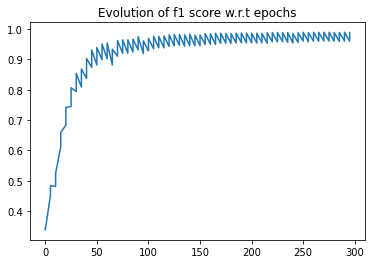

test phase:
F1-Score: 0.9683


GATNet(
  (layers): ModuleList(
    (0): GATConv(
      (fc): Linear(in_features=50, out_features=1024, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (1): GATConv(
      (fc): Linear(in_features=1024, out_features=1024, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (res_fc): Identity()
    )
    (2): GATConv(
      (fc): Linear(in_features=1024, out_features=726, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (res_fc): Linear(in_features=1024, out_features=726, bias=False)
    )
  )
)

In [ ]:
args = Args(mod = 'GAT', epochs=300)
main(args) #F1score at epoch 286 is 0.9700

In [ ]:
train_dataset, test_dataset = LegacyPPIDataset(mode="train"), LegacyPPIDataset(mode="test")
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, collate_fn=collate_fn)
n_features, n_classes = train_dataset.features.shape[1], train_dataset.labels.shape[1]

/usr/local/lib/python3.7/dist-packages/dgl/data/utils.py:286: UserWarning: Property dataset.features will be deprecated, please use dataset.graphs[i].ndata['feat'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
/usr/local/lib/python3.7/dist-packages/dgl/data/utils.py:286: UserWarning: Property dataset.labels will be deprecated, please use dataset.graphs[i].ndata['label'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))


In [ ]:
device = torch.device("cpu" if args.gpu < 0 else "cuda:" + str(args.gpu))

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
model = GATNet(g=train_dataset.graph, input_size=n_features, hidden_size=256,
                  output_size=n_classes,  nonlinearity=F.elu).to(device)
if torch.cuda.is_available():
  map_location=lambda storage, loc: storage.cuda()
else:
  map_location='cpu'
  
MODEL_STATE_FILE = './experiment/model_270.pth'
model.load_state_dict(torch.load(MODEL_STATE_FILE, map_location='cpu'))

<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/dgl/data/utils.py:286: UserWarning: Property dataset.features will be deprecated, please use dataset.graphs[i].ndata['feat'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
/usr/local/lib/python3.7/dist-packages/dgl/data/utils.py:286: UserWarning: Property dataset.labels will be deprecated, please use dataset.graphs[i].ndata['label'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))


using GPU
Epoch 00001 | Loss: 0.7878
F1-Score: 0.2820 
Epoch 00002 | Loss: 0.5492
Epoch 00003 | Loss: 0.5232
Epoch 00004 | Loss: 0.5104
Epoch 00005 | Loss: 0.5034
Epoch 00006 | Loss: 0.4889
F1-Score: 0.4744 
Epoch 00007 | Loss: 0.4819
Epoch 00008 | Loss: 0.4697
Epoch 00009 | Loss: 0.4588
Epoch 00010 | Loss: 0.4528
Epoch 00011 | Loss: 0.4455
F1-Score: 0.5265 
Epoch 00012 | Loss: 0.4290
Epoch 00013 | Loss: 0.4155
Epoch 00014 | Loss: 0.4055
Epoch 00015 | Loss: 0.4034
Epoch 00016 | Loss: 0.3993
F1-Score: 0.6280 
Epoch 00017 | Loss: 0.3879
Epoch 00018 | Loss: 0.3732
Epoch 00019 | Loss: 0.3608
Epoch 00020 | Loss: 0.3510
Epoch 00021 | Loss: 0.3414
F1-Score: 0.6835 
Epoch 00022 | Loss: 0.3344
Epoch 00023 | Loss: 0.3288
Epoch 00024 | Loss: 0.3241
Epoch 00025 | Loss: 0.3187
Epoch 00026 | Loss: 0.3015
F1-Score: 0.7635 
Epoch 00027 | Loss: 0.2890
Epoch 00028 | Loss: 0.2776
Epoch 00029 | Loss: 0.2697
Epoch 00030 | Loss: 0.2629
Epoch 00031 | Loss: 0.2569
F1-Score: 0.7956 
Epoch 00032 | Loss: 0.2510


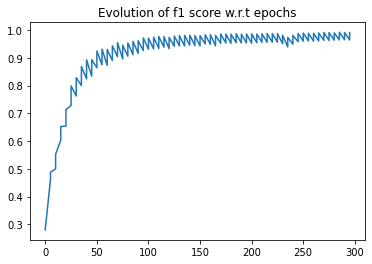

test phase:
F1-Score: 0.9539


GATNet(
  (layers): ModuleList(
    (0): GATConv(
      (fc): Linear(in_features=50, out_features=1024, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (1): GATConv(
      (fc): Linear(in_features=1024, out_features=1024, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (res_fc): Identity()
    )
    (2): GATConv(
      (fc): Linear(in_features=1024, out_features=726, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (res_fc): Linear(in_features=1024, out_features=726, bias=False)
    )
  )
)

In [ ]:
args = Args(mod = 'GAT', epochs=300)
main(args) #F1score at epoch 286 is 0.9700

### Test mode of the best model: F1 score 0.9764

In [ ]:
#MODEL_STATE_FILE = "model_state.pth"
MODEL_STATE_FILE = 'experiment/model_285.pth'

In [ ]:
args = Args(mode="test", mod="GAT")

In [ ]:
main(args)

/usr/local/lib/python3.7/dist-packages/dgl/data/utils.py:286: UserWarning: Property dataset.features will be deprecated, please use dataset.graphs[i].ndata['feat'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
/usr/local/lib/python3.7/dist-packages/dgl/data/utils.py:286: UserWarning: Property dataset.labels will be deprecated, please use dataset.graphs[i].ndata['label'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))


using GPU
test phase:
F1-Score: 0.9764


GATNet(
  (layers): ModuleList(
    (0): GATConv(
      (fc): Linear(in_features=50, out_features=1024, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (1): GATConv(
      (fc): Linear(in_features=1024, out_features=1024, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (res_fc): Identity()
    )
    (2): GATConv(
      (fc): Linear(in_features=1024, out_features=726, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (res_fc): Linear(in_features=1024, out_features=726, bias=False)
    )
  )
)

import script and model weights as 

In [ ]:
#testing script
!python3 train_ppi_baseline.py --mode test

Using backend: pytorch
/usr/local/lib/python3.7/dist-packages/dgl/data/utils.py:286: UserWarning: Property dataset.features will be deprecated, please use dataset.graphs[i].ndata['feat'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
/usr/local/lib/python3.7/dist-packages/dgl/data/utils.py:286: UserWarning: Property dataset.labels will be deprecated, please use dataset.graphs[i].ndata['label'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
Loading model from /content/model_state.pth in location map <function main.<locals>.<lambda> at 0x7fd85b33b710>
F1-Score: 0.9764
